In [1]:
import torch
import numpy as np
import cv2

from scipy.misc import imresize
from pycocotools import mask as maskUtils

import argparse
import time

import numpy as np
import torch
import torchvision.transforms as transforms

from misc.dataset import *
from misc.localization import compute_pointing_game_acc
from misc.model import joint_embedding
from misc.utils import collate_fn_img_padded, collate_fn_cap_padded
from torch.utils.data import DataLoader

from IPython import display

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3,4"

In [2]:
model_path = "weights/best_correct_en.pth.tar"
batch_size = 400

In [3]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

in_dim = (400.0, 400.0)
prepro_val = transforms.Compose([
    transforms.Resize((int(in_dim[0]), int(in_dim[1]))),
    transforms.ToTensor(),
    normalize,
])

In [4]:
print("Loading model from:", model_path)
checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)

join_emb = joint_embedding(checkpoint['args_dict'])
join_emb.load_state_dict(checkpoint["state_dict"])

for param in join_emb.parameters():
    param.requires_grad = False

join_emb = torch.nn.DataParallel(join_emb.cuda().eval())

Loading model from: weights/best_correct_en.pth.tar


In [5]:
def generate_heat_map(act_map, caps_enc, fc_w, nmax=180, in_dim=(400, 400)):
    print("Received :", act_map.shape)
    print("And : ", caps_enc.shape)
    size = act_map.shape[1:]
    act_map = act_map.reshape(act_map.shape[0], -1)
    print(act_map.shape)
    prod = np.dot(fc_w, act_map)

    order = np.argsort(caps_enc)[::-1]
    # print order
    heat_map = np.reshape(
        np.dot(np.abs(caps_enc[order[:nmax]]), prod[order[:nmax]]), size)
    # print heat_map

    #heat_map = np.array(Image.fromarray(heat_map, "").resize(in_dim))
    heat_map = imresize(heat_map, in_dim)

    return heat_map


def gen_binary_heat_map(maps, concept, fc_w, c_thresh, in_dim=(400, 400)):
    hm = generate_heat_map(maps, concept, fc_w, nmax=10, in_dim=in_dim)

    # hm += abs(np.min(hm))

    def thresh(a, coef):
        return coef * (np.max(a) - np.min(a))

    return np.int32(hm > thresh(hm, c_thresh))

In [6]:
def mask_from_poly(polygons, org_size, in_dim):
    mask_poli = np.zeros((org_size[1], org_size[0]))

    for i in range(len(polygons)):
        if polygons[i][0] == "rle":
            m = maskUtils.decode(polygons[i][1])
            mask_poli += m.squeeze()
        else:
            poly = np.int32(np.array(polygons[i]).reshape(
                (int(len(polygons[i]) / 2), 2)))
            cv2.fillPoly(mask_poli, [poly], [1])

    mask_poli = imresize(mask_poli, in_dim, interp="nearest")

    return np.float32(mask_poli > 0)

In [7]:
def compute_semantic_seg(imgs_stack, sizes_list, target_ann, cats_stack, fc_w, c_thresh, in_dim=(200, 200)):

    mAp = 0
    IoUs = dict()
    for k in cats_stack.keys():
        IoUs[k] = list()
        for i in range(imgs_stack.shape[0]):
            if k in target_ann[i]:
                target_mask = mask_from_poly(target_ann[i][k], sizes_list[i], in_dim)

                heat_map = gen_binary_heat_map(imgs_stack[i], cats_stack[k], fc_w, c_thresh, in_dim=in_dim)

                iou = compute_iou(heat_map, target_mask)

                # last element of tuple is groundtruth target
                IoUs[k] += [(iou, 1)]
            else:
                # if categorie k is not present in grountruth set iou at 0
                IoUs[k] += [(0, 0)]

    mAp = list()
    for th in [0.3, 0.4, 0.5]:
        mAp.append(get_map_at(IoUs, th))

    return mAp

In [8]:
def _load_vec(emb_path):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id


In [9]:
dataset = Multi30k(sset='test', transform=prepro_val)
#dataset = CocoSemantic('/data/datasets/coco/', '/data/m.portaz/wiki.multi.en.vec' , transform=prepro_val)

Using multi embeddings


In [137]:
frEmb, _, frWordsID = _load_vec('/data/m.portaz/wiki.multi.fr.vec')
enEmb, _, enWordsID = _load_vec('/data/m.portaz/wiki.multi.en.vec')
deEmb, _, deWordsID = _load_vec('/data/m.portaz/wiki.multi.de.vec')

In [140]:
def getHeatMap(idx, sentence, join_emb, dataset, lang='en'):
    if lang == 'en':
        Emb, WordsID = enEmb, enWordsID
    elif lang == 'fr':
        Emb, WordsID = frEmb, frWordsID
    elif lang == 'de':
        Emb, WordsID = deEmb, deWordsID
        
    input_caps = encode_sentence(sentence, Emb, WordsID, tokenize=True)
    
    act_map = join_emb.module.img_emb.get_activation_map(dataset[idx][0].cuda().unsqueeze(0))
    _, output_cap = join_emb(None, input_caps.cuda().unsqueeze(0), [ len(sentence.split(" ")) ]   )
    
    fc_w = join_emb.module.fc.weight.cpu().data.numpy()
    heat = generate_heat_map(act_map[1][0].cpu().numpy(), output_cap[0].cpu().numpy(), fc_w )
    caption, image = dataset.getImageAndCaption(idx)
    print(caption)
    im = np.array( image.resize( (400,400) )  ) 
    return heat, im
    
def drawHeatMap(heatmap, image):
    heat = np.array(Image.fromarray(heatmap).convert("RGB"))
    masked = np.ma.masked_where(heat > 0, image)
    alpha = 0.3
    display.display(Image.fromarray( (alpha*image).astype(np.uint8) + ((1-alpha)*heat).astype(np.uint8) ))
    return heat

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
an individual wearing rose jacket site idle on a wooden bench .


/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


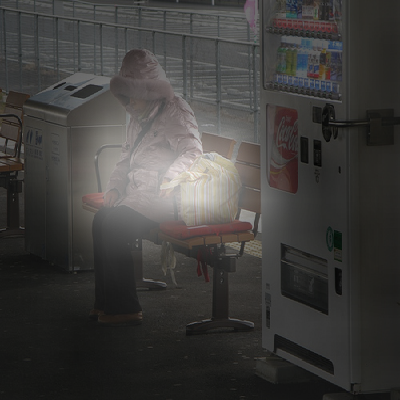

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
an individual wearing rose jacket site idle on a wooden bench .


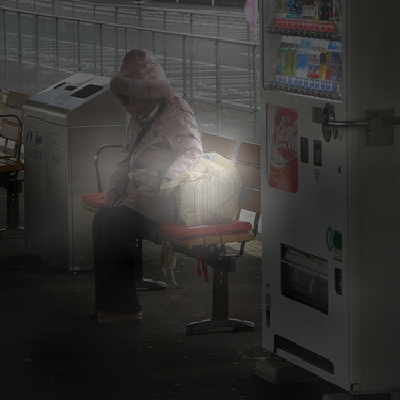

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
an individual wearing rose jacket site idle on a wooden bench .


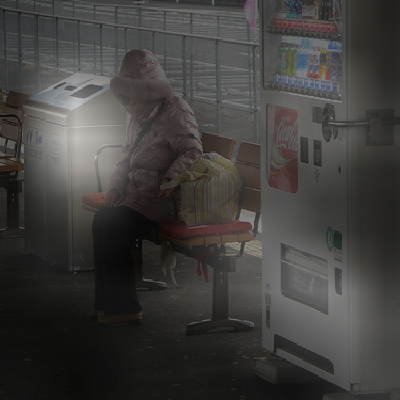

In [147]:
heat, image = getHeatMap(150, "woman", join_emb, dataset, 'en')
h = drawHeatMap(heat, image)
heat, image = getHeatMap(150, "bag", join_emb, dataset, 'en')
h = drawHeatMap(heat, image)
heat, image = getHeatMap(150, "machine", join_emb, dataset, 'en')
h = drawHeatMap(heat, image)

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
on stage photo of small band performing for theater audience .


/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


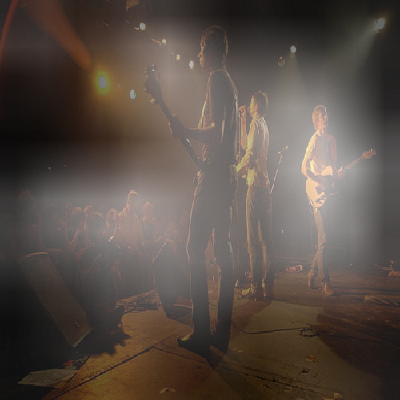

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
on stage photo of small band performing for theater audience .


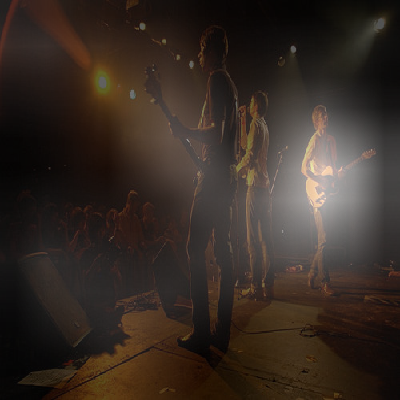

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
on stage photo of small band performing for theater audience .


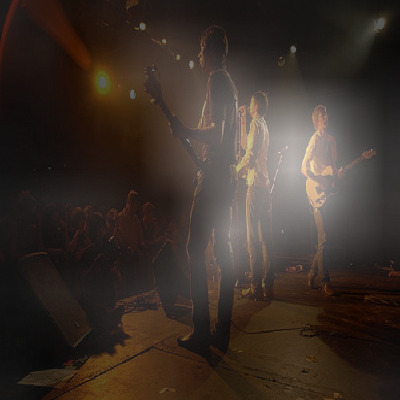

In [148]:
heat, image = getHeatMap(120, "audience", join_emb, dataset, 'en')
h = drawHeatMap(heat, image)
heat, image = getHeatMap(120, "guitariste", join_emb, dataset, 'fr')
h = drawHeatMap(heat, image)
heat, image = getHeatMap(120, "groupe", join_emb, dataset, 'fr')
h = drawHeatMap(heat, image)

Received : (2400, 13, 13)
And :  (2400,)
(2400, 169)
on stage photo of small band performing for theater audience .


/opt/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


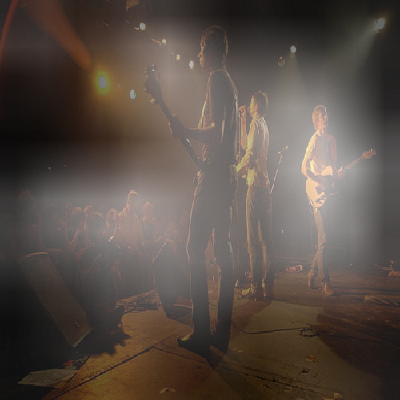

In [131]:
heat, image = getHeatMap(120, "audience", join_emb, dataset, 'en')
h = drawHeatMap(heat, image)